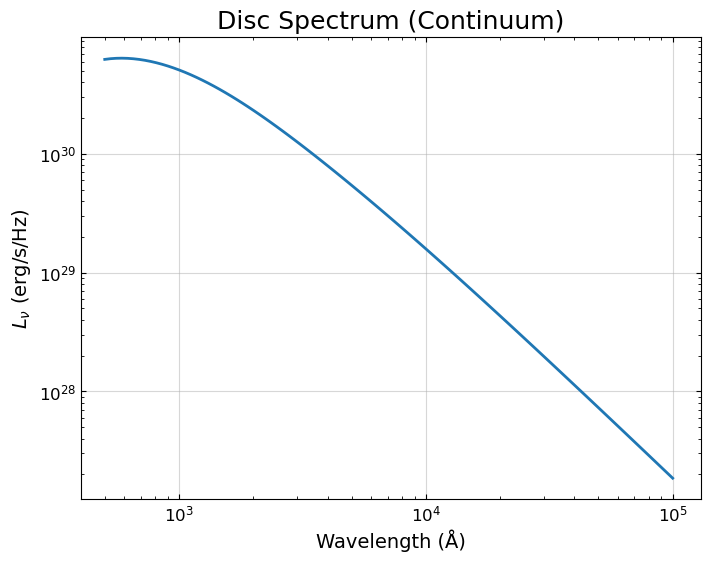

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Put path to the folder with the dll here (the whole thing)
dll_path = r"C:\Users\nikko\Desktop\Dissertation\Code\Comp_SED\SED\.libs"
os.add_dll_directory(dll_path)

import SED

lday = 2.998e8 * 3600*24    # lday to m conversion
Ang = 1e-10                 # Ang to m conversion
deg = np.pi/180             # deg to rad conversion

r = np.array([1, 2, 3]) * lday
dr = np.array([1, 1, 1]) * lday
T = np.array([1e5, 5e4, 1e4])

nr = len(r)
nw = 100

wl_min = 5e2 * Ang
wl_max = 1e5 * Ang

SED_wl_array = np.logspace(np.log10(wl_min), np.log10(wl_max), nw)  # Note - log spacing is not necessary
                                                                    # Can also work with linear spacing

incl = 45 * deg

# Note - Please call the function as follows, otherwise things tend to break
Lnu = SED.sed(
    nr      = nr,           # Number of radial elements
    r_r     = r,            # Radius of the element (in m)
    dr_r    = dr,           # Radial width of the element (in m)
    t_r     = T,            # Temperature (in K)
    nw      = nw,           # Number of wavelengths to compute SED at
    wl      = SED_wl_array, # List of wl values to compute SED at (in m)
    incl    = incl)         # inclination of the object (0 being disc face-on)


fig, ax = plt.subplots(1,1, figsize=(8,6))

ax.loglog(SED_wl_array/Ang, Lnu, linewidth=2, c='C0')
ax.set_xlabel('Wavelength (Å)', fontsize=14)
ax.set_ylabel(r'$L_\nu$ (erg/s/Hz)', fontsize=14)
ax.set_xlim(400, 130000)
ax.grid(alpha=0.5)
ax.tick_params(which='both', top=True, right=True, direction='in', labelsize=12)
ax.set_title('Disc Spectrum (Continuum)', fontsize=18) 

plt.show()

In [ ]:
# Constants
G = 6.674e-11  # Universal gravitational constant (m^3 kg^-1 s^-2)
pi = np.pi     # Pi
c = 2.998e8    # Speed of light (m/s)
h = 6.626e-34  # Planck constant (J s)
sigma = 5.670e-8  # Stefan-Boltzmann constant (W m^-2 K^-4)
kb = 1.381e-23  # Boltzmann constant (J/K)

# Conversion factors
day = 3600 * 24  # Seconds in a day
Msun = 1.988e30  # Solar mass (kg)
erg = 1e-7       # Erg to Joules
lday = c * day   # Light-day in meters
Lsun = 3.828e26  # Solar luminosity (W)
Ang = 1e-10      # Angstrom to meters
year = 3600 * 24 * 365.25  # Seconds in a year
parsec = 3.256 * c * year  # Parsec in meters
erg_mJy = 1e26   # Conversion factor for erg to milliJansky

def planck(freq, temp):
    """
    Computes black body intensity (W/m^2/Hz/sr) at given temperature and frequency.
    
    Parameters:
    freq (float): Frequency in Hz
    temp (float): Temperature in K
    
    Returns:
    float: Black body intensity
    """
    c1 = (2 * kb**3) / (c**2 * h**2)  # (2kb^3)/(c^2h^2)
    c2 = h / kb  # h/kb

    x = c2 * freq / temp

    if x < 1e-5:  # Rayleigh-Jeans tail
        return c1 * (x**2) * (temp**3)
    else:
        return c1 * (x**3) * (temp**3) / (np.exp(x) - 1)

def SED(nr, r_r, dr_r, T_r, nw, wl, incl):
    """
    Computes the Disc SED (with self-occultation).
    
    Parameters:
    nr (int): Number of annular elements
    r_r (array-like): Radial elements (in m)
    dr_r (array-like): Radial thickness of the annulus (in m)
    T_r (array-like): Temperature of annulus (in K)
    nw (int): Number of wavelengths
    wl (array-like): Wavelength range (in m)
    incl (float): Inclination of accretion disc (in radians)
    
    Returns:
    np.ndarray: Lnu (erg/s/Hz)
    """
    n_az = 360
    if incl == 0.0:
        n_az = 1
    daz = 2 * pi / n_az

    # Unit vector towards Earth
    ex = np.sin(incl)
    ez = np.sqrt(1 - ex**2)

    Lnu = np.zeros(nw)

    # Iterate through wavelengths
    for iw in range(nw):
        sum = 0.0
        # Iterate through annuli
        for ir in range(nr):
            rmid = r_r[ir]
            dx = dr_r[ir]
            dA = dx * rmid * daz

            sintilt = 0.0
            costilt = 1.0

            freq = c / wl[iw]
            Bnu = planck(freq, T_r[ir])

            # Iterate through azimuthal angles
            for iaz in range(n_az):
                phi = iaz * daz

                # Normal to surface element
                Ax = -np.cos(phi) * sintilt
                Az = costilt

                dot = Ax * ex + Az * ez

                if dot > 0.0:
                    sum += Bnu * dA * erg

        Lnu[iw] = sum
        # Note - output is in cgs, so to convert to flux at earth, do
        #       Lnu = Lnu / distance / distance
        # Also, distance must be in cm

    return Lnu
